# ECMA 31330 Final Project
### Abby Beckler, Miles Brown

In [180]:
# imports
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Load Data + Use KNN to Impute Missing Values

In [181]:
# set seed to ensure reproducibility
np.random.seed(25)

# load the data
ANES = pd.read_csv('data/ANES.csv')

# remove rows with missing 'pocket', 'retro', and 'trumpft' values
ANES = ANES.dropna(subset=['pocket', 'retro', 'trumpft'])

# impute using k-nearest neighbors imputer
imputer = KNNImputer(n_neighbors=5)
ANES = pd.DataFrame(imputer.fit_transform(ANES), columns=ANES.columns)

# add relevant columns 'pocketEval' and 'econEval'
ANES['pocketEval'] = (ANES['pocket'] - 3) * (-1/2)
ANES['econEval'] = (ANES['retro'] - 3) * (-1/2)

## Perform Initial OLS Regressions (same as K&K)

In [182]:
# regress 'pocketEval' on 'trumpft'
X_pocket = ANES['pocketEval']
X_pocket = sm.add_constant(X_pocket)
y = ANES['trumpft']
model_pocket = sm.OLS(y, X_pocket).fit()

# regresss 'econEval' on 'trumpft'
X_econ = ANES['econEval']
X_econ = sm.add_constant(X_econ)
model_econ = sm.OLS(y, X_econ).fit()

# compare the models
print(model_pocket.summary())
print(model_econ.summary())

                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     304.3
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           6.59e-67
Time:                        14:58:49   Log-Likelihood:                -40764.
No. Observations:                7998   AIC:                         8.153e+04
Df Residuals:                    7996   BIC:                         8.155e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.1407      0.443     90.694      0.0

## More Complex OLS Regressions (+ Covariates)

In [183]:
# create list of covariate columns
covariates = ANES.columns.tolist()
removed = ['trumpft', 'trumpft_post', 'pocket', 'retro', 'pocketEval', 'econEval', 'votepres',
           'bidenft', 'bidenft_post', 'pid_lean', 'pid_strong', 'pid3', 'pid7']
for col in removed:
    covariates.remove(col)

# regress 'trumpft' on 'pocketEval' variable + covariates
X_pocket_cov = ANES[['pocketEval'] + covariates]
X_pocket_cov = sm.add_constant(X_pocket_cov)
model_pocket_cov = sm.OLS(y, X_pocket_cov).fit()

# regress 'trumpft' on 'econEval' variable + covariates
X_econ_cov = ANES[['econEval'] + covariates]
X_econ_cov = sm.add_constant(X_econ_cov)
model_econ_cov = sm.OLS(y, X_econ_cov).fit()

# compare the models with the covariates
# NOTE: the coefficient for pocketEval is no longer significant at p<0.05
print(model_pocket_cov.summary())
print(model_econ_cov.summary())


                            OLS Regression Results                            
Dep. Variable:                trumpft   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1153.
Date:                Thu, 13 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:58:49   Log-Likelihood:                -32617.
No. Observations:                7998   AIC:                         6.533e+04
Df Residuals:                    7949   BIC:                         6.567e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  100.6644 

## Train/Test Split

In [184]:
# train test split the pocket and econ + covariate data
X_pocket_cov_train, X_pocket_cov_test, y_train_pocket, y_test_pocket = train_test_split(X_pocket_cov, y, test_size=0.2, random_state=25)
X_econ_cov_train, X_econ_cov_test, y_train_econ, y_test_econ = train_test_split(X_econ_cov, y, test_size=0.2, random_state=25)

# standardize the data
scaler = MinMaxScaler()
X_pocket_cov_train = scaler.fit_transform(X_pocket_cov_train)
X_pocket_cov_test = scaler.transform(X_pocket_cov_test)
X_econ_cov_train = scaler.fit_transform(X_econ_cov_train)
X_econ_cov_test = scaler.transform(X_econ_cov_test)

X_pocket_cov_train = pd.DataFrame(X_pocket_cov_train, columns=X_pocket_cov.columns)
X_pocket_cov_test = pd.DataFrame(X_pocket_cov_test, columns=X_pocket_cov.columns)
X_econ_cov_train = pd.DataFrame(X_econ_cov_train, columns=X_econ_cov.columns)
X_econ_cov_test = pd.DataFrame(X_econ_cov_test, columns=X_econ_cov.columns)

scaler_y = MinMaxScaler()
y_train_pocket = scaler_y.fit_transform(y_train_pocket.values.reshape(-1, 1))
y_test_pocket = scaler_y.transform(y_test_pocket.values.reshape(-1, 1))
y_train_econ = scaler_y.fit_transform(y_train_econ.values.reshape(-1, 1))
y_test_econ = scaler_y.transform(y_test_econ.values.reshape(-1, 1))

y_train_pocket = pd.DataFrame(y_train_pocket, columns=['trumpft'])
y_test_pocket = pd.DataFrame(y_test_pocket, columns=['trumpft'])
y_train_econ = pd.DataFrame(y_train_econ, columns=['trumpft'])
y_test_econ = pd.DataFrame(y_test_econ, columns=['trumpft'])
#'''


## LASSO Regression

In [185]:

# fit LASSO models
lasso_pocket = Lasso(alpha=0.5, random_state=25)
lasso_pocket.fit(X_pocket_cov_train, y_train_pocket)

lasso_econ = Lasso(alpha=0.5, random_state=25)
lasso_econ.fit(X_econ_cov_train, y_train_econ)

# compute test accuracy for the models
print('Test accuracy for pocketEval model:', lasso_pocket.score(X_pocket_cov_test, y_test_pocket))
print('Test accuracy for econEval model:', lasso_econ.score(X_econ_cov_test, y_test_econ))

# compare the selected features for the two models
print('Selected features for pocketEval model:')
print(X_pocket_cov.columns[lasso_pocket.coef_ != 0])
print('Number of selected features:', sum(lasso_pocket.coef_ != 0))

print('Selected features for econEval model:')
print(X_econ_cov.columns[lasso_econ.coef_ != 0])
print('Number of selected features:', sum(lasso_econ.coef_ != 0))

Test accuracy for pocketEval model: -0.00044637604523023455
Test accuracy for econEval model: -0.00044637604523023455
Selected features for pocketEval model:
Index([], dtype='object')
Number of selected features: 0
Selected features for econEval model:
Index([], dtype='object')
Number of selected features: 0


## Neural Network (?)

In [ ]:
# train a neural network on pocketEval model
class ANESDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ANESNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANESNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = X_pocket_cov_train.shape[1]
hidden_dim = 100
output_dim = 1



def train_model(X_train_model, y_train_model, X_test_model, y_test_model, input_dim, hidden_dim, output_dim, n_epochs=100):
    anes_net = ANESNet(input_dim, hidden_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(anes_net.parameters(), lr=0.0002)

    anes_train = ANESDataset(X_train_model, y_train_model)
    anes_test = ANESDataset(X_test_model, y_test_model)

    train_loader = DataLoader(anes_train, batch_size=128, shuffle=True)
    test_loader = DataLoader(anes_test, batch_size=128, shuffle=False)


    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        anes_net.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = anes_net(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        anes_net.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = anes_net(X_batch)
                loss = criterion(output, y_batch)
                test_loss += loss.item()
            print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Test Loss: {test_loss / len(test_loader)}')
            test_losses.append(test_loss / len(test_loader))
    return anes_net, test_loader

anes_net_pocket, anes_loader = train_model(X_pocket_cov_train, y_train_pocket, X_pocket_cov_test, y_test_pocket, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.5175199061632156, Test Loss: 0.19067928194999695
Epoch 2, Train Loss: 0.3604026061296463, Test Loss: 0.1216944524875054
Epoch 3, Train Loss: 0.30354381442070005, Test Loss: 0.09306173198498212
Epoch 4, Train Loss: 0.2899491673707962, Test Loss: 0.07864504078259835
Epoch 5, Train Loss: 0.2500962606072426, Test Loss: 0.068344303048574
Epoch 6, Train Loss: 0.25110657036304473, Test Loss: 0.06380562398296136
Epoch 7, Train Loss: 0.2215747880935669, Test Loss: 0.06243480541385137
Epoch 8, Train Loss: 0.213072352707386, Test Loss: 0.05900431882876616
Epoch 9, Train Loss: 0.20024178832769393, Test Loss: 0.05330682746492899
Epoch 10, Train Loss: 0.18832837045192719, Test Loss: 0.04814416456681032
Epoch 11, Train Loss: 0.17531770557165147, Test Loss: 0.04979142030844322
Epoch 12, Train Loss: 0.1626262465119362, Test Loss: 0.046115329345831506
Epoch 13, Train Loss: 0.15358027517795564, Test Loss: 0.04243658454372333
Epoch 14, Train Loss: 0.1437341406941414, Test Loss: 0.04

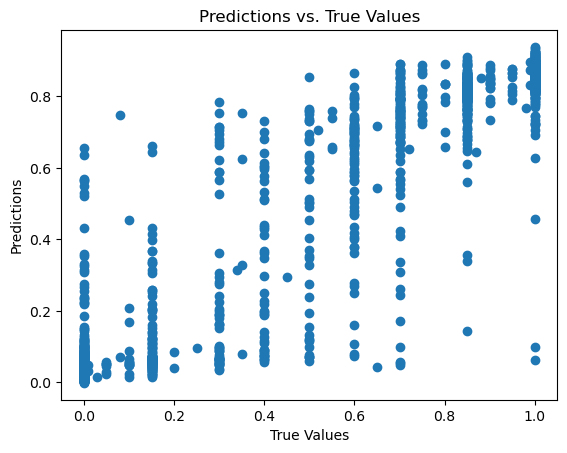

In [198]:
anes_net_pocket.eval()
pocket_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_pocket(X_batch)
        pocket_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_pocket, pocket_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.show()


In [199]:
# train a neural network on econEval model
input_dim = X_econ_cov_train.shape[1]
anes_net_econ, anes_loader = train_model(X_econ_cov_train, y_train_econ, X_econ_cov_test, y_test_econ, input_dim, hidden_dim, output_dim)

Epoch 1, Train Loss: 0.3427252548933029, Test Loss: 0.13130216300487518
Epoch 2, Train Loss: 0.2941264858841896, Test Loss: 0.09660982455198582
Epoch 3, Train Loss: 0.2520520949363709, Test Loss: 0.08211596080890068
Epoch 4, Train Loss: 0.21987635850906373, Test Loss: 0.08040641534786958
Epoch 5, Train Loss: 0.19983385860919953, Test Loss: 0.06871226544563587
Epoch 6, Train Loss: 0.19374500155448915, Test Loss: 0.06934724518885979
Epoch 7, Train Loss: 0.16936664462089537, Test Loss: 0.06865723001269194
Epoch 8, Train Loss: 0.16330852568149568, Test Loss: 0.06315525535207528
Epoch 9, Train Loss: 0.1485540011525154, Test Loss: 0.060959871571797594
Epoch 10, Train Loss: 0.13380952984094618, Test Loss: 0.06058649460856731
Epoch 11, Train Loss: 0.13071534514427186, Test Loss: 0.05746365252595682
Epoch 12, Train Loss: 0.1245171619951725, Test Loss: 0.056733900537857644
Epoch 13, Train Loss: 0.11526807516813278, Test Loss: 0.057076774251002535
Epoch 14, Train Loss: 0.10923322632908822, Test L

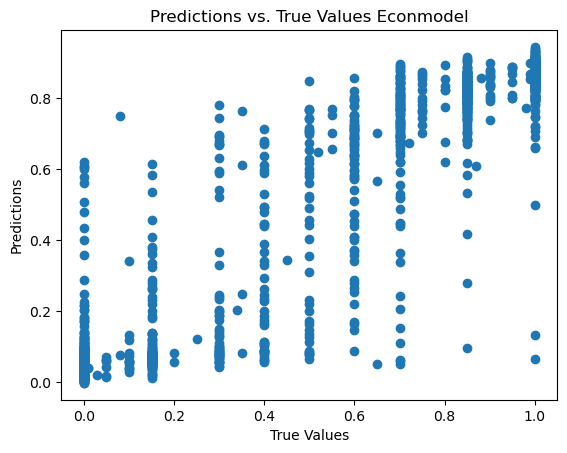

R^2 value for pocketEval model: 0.8714815332841142
R^2 value for econEval model: 0.8735279653308412


In [200]:
anes_net_econ.eval()
econ_predictions = []
with torch.no_grad():
    for X_batch, y_batch in anes_loader:
        output = anes_net_econ(X_batch)
        econ_predictions.extend(output.numpy().flatten())

# plot the predictions vs. true values
plt.scatter(y_test_econ, econ_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values Econmodel')
plt.show()

from sklearn.metrics import r2_score
print('R^2 value for pocketEval model:', r2_score(y_test_pocket, pocket_predictions))
print('R^2 value for econEval model:', r2_score(y_test_econ, econ_predictions))

## Random Forest

In [201]:
# run a Random Forest on pocketEval test data and covariates
rf_pocket = RandomForestRegressor(n_estimators=500, random_state=25)
rf_pocket.fit(X_pocket_cov_train, y_train_pocket)

feature_importance_pocket = pd.DataFrame({
    "Feature": X_pocket_cov.columns,
    "Importance": rf_pocket.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_pocket.head(10)

# get random forest prediction accuracy on pocket test
rf_pocket.score(X_pocket_cov_test, y_test_pocket)
print('Random Forest accuracy on pocketEval model:', rf_pocket.score(X_pocket_cov_test, y_test_pocket))

c:\Users\miles\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest accuracy on pocketEval model: 0.885205539917285


In [ ]:
# run a Random Forest on econEval and covariates
rf_econ = RandomForestRegressor(n_estimators=500, random_state=25)
rf_econ.fit(X_econ_cov_train, y_train_econ)

feature_importance_econ = pd.DataFrame({
    "Feature": X_econ_cov.columns,
    "Importance": rf_econ.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance_econ.head(10)

# get random forest prediction accuracy on econ test
rf_econ.score(X_econ_cov_test, y_test_econ)
print('Random Forest accuracy on econEval model:', rf_econ.score(X_econ_cov_test, y_test_econ))

c:\Users\miles\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
